# Swing-amplification spiral ODE-solver

## Problem
Swing-amplification as a spiral-arm formation mechanism makes predictions about the shape of spiral arms (at least using linear density wave theory).
Can we test those predictions against 

## Method
Assume the galaxy has a flat roation curve. The equation for a flat rotation curve is
$$\Omega = \frac{a}{2\pi r}\tanh{br}.$$

Thus the rotational shear of a flat rotation curve is given by
$$\Gamma = -\frac{d\log\Omega}{d\log{r}} = -r\frac{d\ln\Omega}{dr} = 1 - \frac{4 b r e^{2br}}{e^{4br} - 1}.$$

Swing-amplification predicts that the spiral arm's pitch angle $\phi$ is approximately
$$\tan\phi \approx \frac{2}{7}\frac{\sqrt{4 - 2\Gamma}}{\Gamma}.$$

Combining this with the definition of pitch angle (note that constant $\phi$ results in log spiral $r=ae^{\theta\tan{\phi}}$) gives
$$\frac{r'}{r} = \tan\phi \approx \frac{2}{7}\frac{\sqrt{4 - 2\Gamma}}{\Gamma}.$$

Define $R := 2br$, we then have that
$$\Gamma = 1 - \frac{2 R e^{R}}{e^{R} - 1} = 1 - \frac{R}{\sinh{R}}.$$
$$\frac{\mathrm{d}R}{\mathrm{d}\theta} = R' = \frac{2\sqrt{2}}{7}R\frac{\sqrt{1 + \frac{R}{\sinh{R}}}}{1 - \frac{R}{\sinh{R}}}.$$

Given 
$$\frac{\mathrm{d}R}{\mathrm{d}\theta} = \frac{\mathrm{d}R}{\mathrm{d}r}\frac{\mathrm{d}r}{\mathrm{d}\theta} = 2br',$$

We obtain the differential equation
$$r' = \frac{2\sqrt{2}}{7}r\frac{\sqrt{1 + \frac{2br}{\sinh{2br}}}}{1 - \frac{2br}{\sinh{2br}}}.$$


In [57]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from scipy import optimize
from IPython.display import display
from numba import jit
from gzbuilderspirals import fitting
from gzbuilderspirals import xy_from_r_theta, get_pitch_angle
from IPython.display import display

In [2]:
plt.style.use('seaborn')

In [3]:
N = 500
theta = np.linspace(1, 2* np.pi, N)

@jit(nopython=True)
def dydt(r, theta, b):
    R = 2 * b * r
    s = np.sinh(R)
    return (
        2*np.sqrt(2) / 7 * r
        * np.sqrt(1 + R / s) / (1 - R / s)
    )
# call to trigger a numba compilation (use odeint to ensure 
# consistent function signature)
%timeit _ = odeint(dydt, 1, theta, args=(1,))[:, 0]

303 µs ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


What does varying the parameters do to the distributions?

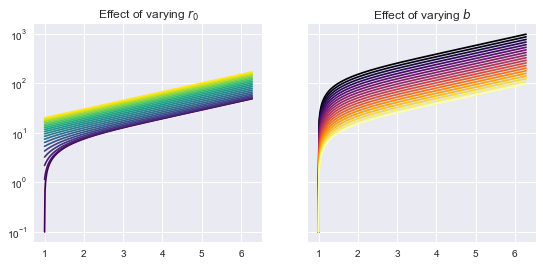

In [37]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))
plt.sca(ax[0])
colors = plt.cm.viridis(np.linspace(0, 1, 20))
for i, r0 in enumerate(np.linspace(0.1, 20, 20)):
  y = odeint(dydt, r0, theta, args=(0.2,))[:, 0]
  plt.plot(theta, y, c=colors[i])
plt.yscale('log')
plt.title('Effect of varying $r_0$')
plt.sca(ax[1])
colors = plt.cm.inferno(np.linspace(0,1,20))
for i, b in enumerate(10**(np.linspace(-2, -1, 20))):
  y = odeint(dydt, 0.1, theta, args=(b,))[:, 0]
  plt.plot(theta, y, c=colors[i])
plt.yscale('log')
plt.title('Effect of varying $b$');

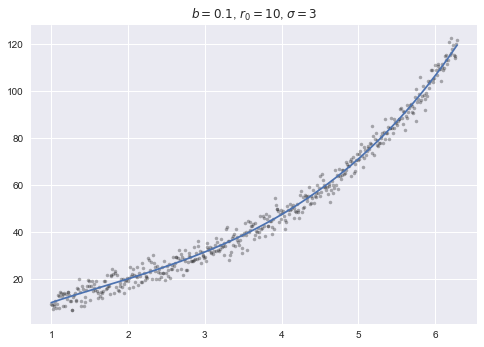

In [5]:
true_b = 0.1
true_r0 = 10
true_sigma = 3
y = odeint(dydt, true_r0, theta, args=(true_b,))[:, 0]
noise = np.random.normal(size=theta.size, scale=true_sigma)
y_obs = y + noise
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0')
plt.title(r'$b = {}$, $r_0 = {}$, $\sigma = {}$'.format(true_b, true_r0, true_sigma));

This is a difficult-to-solve problem, as combinations of parameters very different from the true values can create realistic outputs, for example:

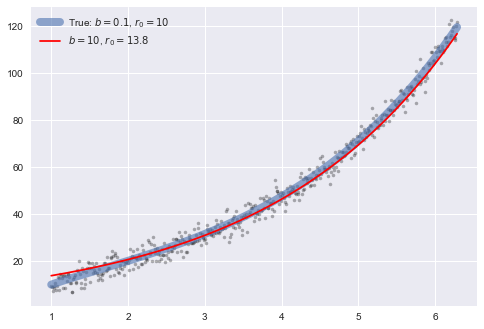

In [6]:
bad_b = 10
bad_r0 = 13.8
bad_y = odeint(dydt, bad_r0, theta, args=(bad_b,))[:, 0]
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0', linewidth=8, alpha=0.6, label='True: $b = {}$, $r_0 = {}$'.format(true_b, true_r0))
plt.plot(theta, bad_y, 'r', label='$b = {}$, $r_0 = {}$'.format(bad_b, bad_r0))
plt.legend();

A log spiral would also be an acceptable profile!

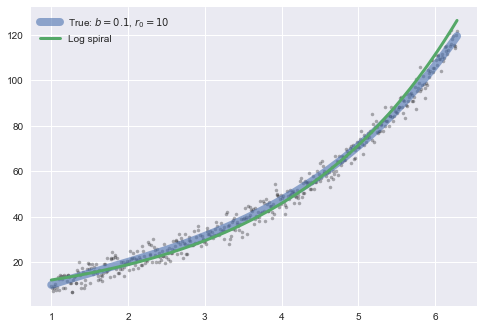

In [7]:
logsp_model = fitting.get_log_spiral_pipeline()
logsp_model.fit(theta[y_obs > 0].reshape(-1, 1), y_obs[y_obs > 0])
t_predict = np.linspace(min(theta), max(theta), 500)
y_logsp = logsp_model.predict(t_predict.reshape(-1, 1))
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0', linewidth=8, alpha=0.6, label='True: $b = {}$, $r_0 = {}$'.format(true_b, true_r0))
plt.plot(t_predict, y_logsp, 'C1', linewidth=3, label='Log spiral')
plt.legend();

Let's get some sensible starting guesses, optimize the absolute error of the odeint

Guesses from regression:
	b: 0.0979, r_0: 9.5427, sigma: 2.9679
Errors on guesses:
	b: 2.07%, r_0: 4.57%, sigma: 1.07%


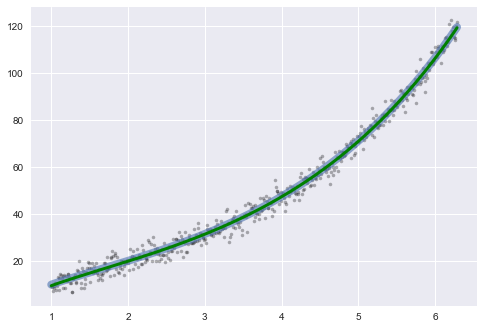

In [8]:
cmap = plt.cm.get_cmap('Spectral')
def f(p, score_func=mean_squared_error):
    b, r0 = p
    y = odeint(dydt, r0, theta, args=(b,))[:, 0]
    return score_func(y, y_obs)

# If you want to use r2_score as loss function, uncomment below
LOSS_FUNCTION = lambda a, b: 1-r2_score(a, b)

res = optimize.minimize(
    f, (0.1, 10), # args=(LOSS_FUNCTION,)
)

guess_b, guess_r0 = res['x']
y_guess = odeint(dydt, guess_r0, theta, args=(guess_b,))[:, 0]
guess_sigma = (y_obs - y_guess).std()
print('Guesses from regression:')
print('\tb: {:.4f}, r_0: {:.4f}, sigma: {:.4f}'.format(
    guess_b, guess_r0, guess_sigma
))
print('Errors on guesses:')
print('\tb: {:.2%}, r_0: {:.2%}, sigma: {:.2%}'.format(
    abs(true_b - guess_b) / true_b,
  abs(true_r0 - guess_r0) / true_r0,
  abs(true_sigma - guess_sigma) / true_sigma
))
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0', linewidth=8, alpha=0.6)
plt.plot(theta, y_guess, 'g', linewidth=3);

Okay, that's a pretty good starting point! Compare the possible fits using their r2 score:

In [9]:
from sklearn.metrics import r2_score
print('{:<30} {:.4f}'.format('True value:', r2_score(y_obs, y)))
print('{:<30} {:.4f}'.format('Swing amplified spiral:', r2_score(y_obs, y_guess)))
print('{:<30} {:.4f}'.format('Bad swing amplified spiral:', r2_score(y_obs, bad_y)))
print('{:<30} {:.4f}'.format('Log spiral:', r2_score(y_obs, y_logsp)))

True value:                    0.9903
Swing amplified spiral:        0.9904
Bad swing amplified spiral:    0.9876
Log spiral:                    0.9854


It's a pretty close race...

## Monte Carlo solving

Let's feed this into a `pymc3` solver which makes use of the RK4 algorithm coded in theano (thanks Coleman!).

Priors can be seen in the diagram below. All distributions have their test value set to the result from the fit. 

*It appears that pymc3 no longer works in Nteract **:sadface:** *

In [10]:
# import pymc3 as pm
# import theano
# import theano.tensor as tt

In [11]:
# C = 2 * np.sqrt(2) / 7

# def theano_dydt(r, theta, b):
#     R = 2 * b * r
#     s = tt.sinh(R)
#     return C * r * tt.sqrt(1 + R / s) / (1 - R / s)

# def theano_rk4(t, t_m1, y, *args):
#     dt = t - t_m1
#     k1 = dt * theano_dydt(y, t, *args)
#     k2 = dt * theano_dydt(y + 0.5 * k1, t, *args)
#     k3 = dt * theano_dydt(y + 0.5 * k2, t, *args)
#     k4 = dt * theano_dydt(y + k3, t, *args)
#     y_np1 = y + (1./6.)*k1 + (1./3.)*k2 + (1./3.)*k3 + (1./6.)*k4
#     return y_np1

# with pm.Model() as mdl_ode:
#     logB = pm.Normal('logB', mu=0, sd=10, testval=np.log(guess_b))
#     B = tt.exp(logB)
#     r_0 = pm.Uniform('r_0', lower=0, upper=100, testval=guess_r0)
#     sigma = pm.Exponential('sigma', lam=0.05, testval=guess_sigma)
    
#     y_est, updates = theano.scan(
#         fn=theano_rk4,
#         sequences=[
#             {'input': tt.as_tensor(theta), 'taps': [0, -1]}
#         ],
#         outputs_info=r_0,
#         non_sequences=[
#             B,
#         ]
#     )

#     y_est = tt.concatenate([[r_0], y_est])
#     likelihood = pm.Normal('likelihood', mu=y_est, sd=sigma, observed=y_obs)

In [12]:
# display(pm.model_to_graphviz(mdl_ode))

In [13]:
# with mdl_ode:
#     traces_ols = pm.sample(500, tune=500)

# display(pm.summary(traces_ols))

How have our chains behaved relative to the true values?

In [14]:
# pm.traceplot(traces_ols, lines={'logB': np.log(true_b), 'sigma': true_sigma, 'r_0': true_r0},
#              combined=False);

Our posterior KDEs look like:

In [15]:
# pm.plots.plot_posterior(traces_ols);

# Real data

Okay, so it works in principle. What about for galaxy builder classifications?

In [16]:
from gzbuilderspirals.oo import Arm
a = Arm.load('lib/spiral_arms/20902001-0.pickle')
arm = Arm(a.get_parent(), a.arms)
arm

In [17]:
print('Log spiral pitch angle: {:.2f} ± {:.3f}˚'.format(arm.pa, arm.sigma_pa))

Log spiral pitch angle: 30.65 ± 0.489˚


In [18]:
t_gal = arm.t[np.argsort(arm.t)]
R_gal = arm.R[np.argsort(arm.t)] * 512
groups_gal = arm.groups[np.argsort(arm.t)]
R_logsp = arm.logsp_model.predict(t_gal.reshape(-1, 1)) * 512
if arm.chirality < 1:
    t_gal = np.flip(-t_gal)
    R_gal = np.flip(R_gal)
    R_logsp = np.flip(R_logsp)

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

In [20]:
def f_gal(p, X=t_gal, y=R_gal, point_weights=arm.point_weights):
    # p = (b, r0)
    yp = odeint(dydt, p[1], X, args=(p[0],))[:, 0]
    return mean_squared_error(yp, y, sample_weight=point_weights)

def sa_weighted_group_cross_val(X, y, cv, groups, weights, p0=(0.1, 20)):
    scores = np.zeros(cv.get_n_splits(X, y, groups=groups))
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        group_weights = weights[train] / weights[train].mean()

        _f = lambda p: f_gal(p, X=X_train, y=y_train, point_weights=group_weights)
        res = optimize.minimize(_f, p0)
        guess_b, guess_r0 = res['x']

        y_pred = odeint(dydt, guess_r0, X_test, args=(guess_b,))[:, 0]
        score = r2_score(y_pred, y_test)
        
        plt.plot(X_train, y_train, '.', alpha=0.4)
        plt.plot(X_test, y_pred)
        scores[i] = score
    return scores

array([0.74170478, 0.77898871])

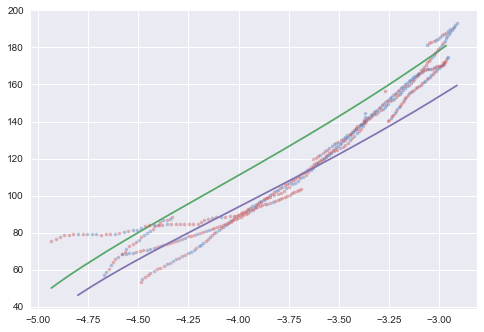

In [21]:
gkf = GroupKFold(n_splits=2)
sa_weighted_group_cross_val(t_gal, R_gal, gkf, groups_gal, arm.point_weights)

In [22]:
%time res = optimize.minimize(f_gal, (0.1, 20))
guess_b, guess_r0 = res['x']
y_guess = odeint(dydt, guess_r0, t_gal, args=(guess_b,))[:, 0]
guess_sigma = (R_gal - y_guess).std()

CPU times: user 328 ms, sys: 11.3 ms, total: 339 ms
Wall time: 397 ms


Swing amplified spiral:   0.9157
Log spiral:               0.9641


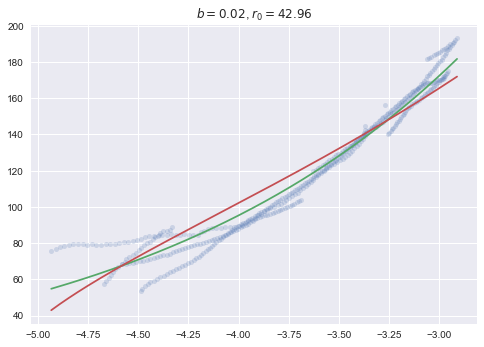

In [23]:
plt.plot(t_gal, R_gal, '.', markersize=10, alpha=0.2)
plt.plot(t_gal, R_logsp)
plt.plot(t_gal, y_guess)
plt.title(r'$b = {:.2f}$, $r_0 = {:.2f}$'.format(guess_b, guess_r0));
# plt.yscale('log')
print('{:<25} {:.4f}'.format('Swing amplified spiral:', r2_score(R_gal, y_guess)))
print('{:<25} {:.4f}'.format('Log spiral:', r2_score(R_gal, R_logsp)))